In [1]:
if 1:
    !nvidia-smi
    
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book
    
    from google.colab import drive
    #drive.mount('/content/drive')

import fastai.test_utils
fastai.test_utils.show_install()

Thu May  6 15:51:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Human Numbers

In [2]:
from fastai.text.all import *

In [3]:
bs = 64

# Data

In [4]:
path = untar_data(URLs.HUMAN_NUMBERS)

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/human_numbers/train.txt'),Path('/root/.fastai/data/human_numbers/valid.txt')]

In [6]:
def readnums(fn): return ', '.join([o.strip() for o in (path/fn).readlines()])

In [7]:
train_txt = readnums('train.txt')

In [8]:
valid_txt = readnums('valid.txt')

In [9]:
train_txt[:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [10]:
valid_txt[:80]

'eight thousand one, eight thousand two, eight thousand three, eight thousand fou'

In [11]:
train_tok = tokenize1(train_txt, tok=WordTokenizer())
valid_tok = tokenize1(valid_txt, tok=WordTokenizer())

In [12]:
dsets = Datasets([train_tok, valid_tok], tfms=Numericalize, dl_type=LMDataLoader, splits=[[0], [1]])

In [13]:
dls = dsets.dataloaders(bs=bs, val_bs=bs)

In [14]:
dsets.show((dsets.train[0][0][:80],)) # ???

In [15]:
len(dsets.valid[0][0])

13017

In [16]:
dls.seq_len, len(dls.valid)

(72, 3)

In [17]:
13017/72/bs # -> len(dls.valid)

2.8248697916666665

In [18]:
dls.valid

In [19]:
it = iter(dls.valid)
x1, y1 = next(it)
x2, y2 = next(it)
x3, y3 = next(it)
it.close()

In [20]:
x1.numel() + x2.numel() + x3.numel()

12992

In [21]:
x1.shape, x2.shape, x3.shape

(torch.Size([64, 72]), torch.Size([64, 72]), torch.Size([64, 59]))

In [22]:
x1.shape, y1.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [23]:
x3.shape, y3.shape

(torch.Size([64, 59]), torch.Size([64, 59]))

In [24]:
x1[0]

LMTensorText([ 2, 19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19, 11, 16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,  9, 19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,
         9, 19, 11, 32,  9, 19, 11, 33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11, 37], device='cuda:0')

In [25]:
y1[0]

TensorText([19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19, 11, 16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,  9, 19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9,
        19, 11, 32,  9, 19, 11, 33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11, 37,  9], device='cuda:0')

In [26]:
v = dls.vocab

In [27]:
type(v)

list

In [28]:
def translate(t): return ' '.join(v[n] for n in t)

In [29]:
translate(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand eighteen'

In [30]:
translate(y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand eighteen ,'

In [31]:
translate(x2[0])

', eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two , eight thousand thirty three'

In [32]:
translate(x3[0])

', eight thousand thirty four , eight thousand thirty five , eight thousand thirty six , eight thousand thirty seven , eight thousand thirty eight , eight thousand thirty nine , eight thousand forty , eight thousand forty one , eight thousand forty two , eight thousand forty three , eight thousand forty four , eight thousand forty five'

In [33]:
translate(x1[1])

', eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand'

# Models

## Single fully connected model

In [34]:
dls = dsets.dataloaders(bs=bs, seq_len=3)

In [35]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [36]:
nv = len(v)
nv

40

In [37]:
nh = 64

In [38]:
def loss4(input, target): return F.cross_entropy(input, target[:,-1])
def acc4(input, target): return accuracy(input, target[:,-1])

In [39]:
class Model0(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1] > 1:
            h += self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1] > 2:
            h += self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [40]:
learn = Learner(dls, Model0(), loss_func=loss4, metrics=acc4)

In [41]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.668519,3.556182,0.114890,00:07
1,2.706007,2.669069,0.434972,00:07
2,2.171068,2.272865,0.452895,00:07
3,1.957341,2.133182,0.463695,00:07
4,1.878460,2.091137,0.464384,00:07
5,1.862082,2.085324,0.465303,00:07


## Loop

In [42]:
class Model1(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh, device=x.device)
        for i in range(x.shape[1]):
            h += self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [43]:
learn = Learner(dls, Model1(), loss_func=loss4, metrics=acc4)

In [44]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.536849,3.449934,0.146599,00:07
1,2.599187,2.601222,0.434513,00:07
2,2.112342,2.250949,0.457950,00:07
3,1.914961,2.131899,0.466452,00:07
4,1.841329,2.096974,0.468290,00:07
5,1.825940,2.092289,0.468061,00:07


## Multi fully connected model

In [45]:
dls = dsets.dataloaders(bs=bs, seq_len=20)

In [46]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [47]:
class Model2(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            #h += self.i_h(x[:,i]) # += doesnt work for some reason
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.h_o(self.bn(h)))
        return torch.stack(res, dim=1)
        

In [48]:
learn = Learner(dls, Model2(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [49]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.820956,3.826341,0.012855,00:01
1,3.731943,3.690244,0.055421,00:01
2,3.546662,3.486009,0.156321,00:01
3,3.315488,3.290039,0.228717,00:02
4,3.085828,3.124444,0.301184,00:01
5,2.889407,3.002360,0.319271,00:01
6,2.740244,2.925682,0.345573,00:01
7,2.638045,2.884141,0.350971,00:02
8,2.575850,2.868013,0.352746,00:01
9,2.543473,2.865587,0.353385,00:01


# Maintain State

In [61]:
class Model3(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs,nh).cuda()
        
    def forward(self,x):
        if self.h.shape[0] != x.shape[0]: self.h = torch.zeros(x.shape[0], nh).cuda()
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
            res.append(h)
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res
    
    def reset(self): self.h = torch.zeros(bs,nh).cuda()

In [62]:
learn = Learner(dls, Model3(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.015848932787775993)

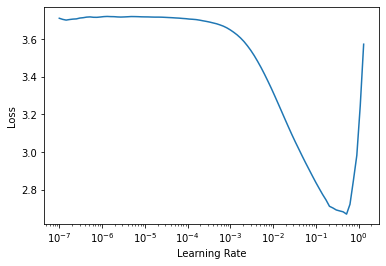

In [63]:
learn.lr_find()

In [64]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.416499,3.240493,0.276491,00:01
1,2.759272,2.295817,0.469697,00:01
2,2.097893,1.986054,0.468963,00:01
3,1.668774,1.715289,0.507268,00:01
4,1.374632,1.759209,0.552794,00:01
5,1.137015,1.842895,0.574503,00:01
6,0.944651,1.810307,0.561529,00:01
7,0.789271,1.848894,0.569413,00:01
8,0.663580,1.805754,0.605492,00:01
9,0.564070,1.707893,0.612216,00:01


# nn.RNN

In [71]:
class Model4(Module):
    def __init__(self):
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self,x):
        if x.shape[0] != self.h.shape[1]: self.h = torch.zeros(1,x.shape[0],nh).cuda()
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [72]:
learn = Learner(dls, Model4(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [73]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.636480,3.518799,0.166738,00:01
1,2.848403,2.319090,0.463092,00:01
2,2.116145,2.142850,0.318750,00:01
3,1.749273,2.081407,0.322301,00:01
4,1.557211,1.813204,0.468561,00:01
5,1.432513,1.827086,0.462618,00:01
6,1.281016,1.678441,0.505303,00:01
7,1.123876,1.709181,0.504380,00:01
8,0.979809,1.747367,0.507363,00:01
9,0.855171,1.678571,0.521520,00:01


## 2-layer GRU

In [74]:
class Model5(Module):
  def __init__(self):
    self.i_h = nn.Embedding(nv,nh)
    self.rnn = nn.GRU(nh,nh,2, batch_first=True)
    self.h_o = nn.Linear(nh,nv)
    self.bn = BatchNorm1dFlat(nh)
    self.h = torch.zeros(2,bs,nh).cuda()

  def forward(self,x):
    if x.shape[0] != self.h.shape[1]: self.h = torch.zeros(2,x.shape[0],nh).cuda()
    res, h = self.rnn(self.i_h(x), self.h)
    self.h = h.detach()
    return self.h_o(self.bn(res))

In [75]:
learn = Learner(dls, Model5(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [77]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.012540,1.037780,0.836600,00:01
1,0.018713,1.617007,0.766170,00:01
2,0.038963,1.610294,0.805374,00:01
3,0.041251,1.326038,0.823911,00:01
4,0.031759,1.237135,0.838944,00:01
5,0.021791,1.401740,0.826870,00:01
6,0.014147,1.380242,0.835677,00:01
7,0.008773,1.393748,0.829309,00:01
8,0.005254,1.436987,0.830824,00:01
9,0.003390,1.438098,0.830137,00:01
